In [49]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [50]:
shake_bi = pd.read_csv('../data/bigram_titles_pos.csv')
shake_tri = pd.read_csv('../data/trigram_titles_pos.csv')
shake_four = pd.read_csv('../data/fourgram_titles_pos.csv')

In [51]:
shake_bi.sample(5)

,title,title_tokenized,pos_tag,good_title,pos,pos1,pos2
45,midnight hag,"['midnight', 'hag']","['NN', 'NN']",1,"['NN', 'NN']",NN,NN
214,is bitter,"['is', 'bitter']","['VBZ', 'JJ']",0,"['VBZ', 'JJ']",VBZ,JJ
19,sweet poison,"['sweet', 'poison']","['JJ', 'NN']",1,"['JJ', 'NN']",JJ,NN
115,casual slaughters,"['casual', 'slaughters']","['JJ', 'NNS']",1,"['JJ', 'NNS']",JJ,NNS
81,present laughter,"['present', 'laughter']","['JJ', 'NN']",1,"['JJ', 'NN']",JJ,NN


In [52]:
shake_tri.sample(5)

,title,title_tokenized,pos_tag,good_title,pos,pos1,pos2,pos3
30,taste of death,"['taste', 'of', 'death']","['NN', 'IN', 'NN']",1,"['NN', 'IN', 'NN']",NN,IN,NN
254,they call the,"['they', 'call', 'the']","['PRP', 'VBP', 'DT']",0,"['PRP', 'VBP', 'DT']",PRP,VBP,DT
14,by the book,"['by', 'the', 'book']","['IN', 'DT', 'NN']",1,"['IN', 'DT', 'NN']",IN,DT,NN
170,some must watch,"['some', 'must', 'watch']","['DT', 'MD', 'VB']",1,"['DT', 'MD', 'VB']",DT,MD,VB
279,alley up and,"['alley', 'up', 'and']","['VB', 'RP', 'CC']",0,"['VB', 'RP', 'CC']",VB,RP,CC


In [53]:
shake_four.sample(5)

,title,title_tokenized,pos_tag,good_title,pos,pos1,pos2,pos3,pos4
149,day will it be,"['day', 'will', 'it', 'be']","['NN', 'MD', 'PRP', 'VB']",0,"['NN', 'MD', 'PRP', 'VB']",NN,MD,PRP,VB
49,that he is a,"['that', 'he', 'is', 'a']","['IN', 'PRP', 'VBZ', 'DT']",0,"['IN', 'PRP', 'VBZ', 'DT']",IN,PRP,VBZ,DT
254,too like the lightning,"['too', 'like', 'the', 'lightning']","['RB', 'IN', 'DT', 'NN']",1,"['RB', 'IN', 'DT', 'NN']",RB,IN,DT,NN
182,summon up the blood,"['summon', 'up', 'the', 'blood']","['VB', 'RP', 'DT', 'NN']",1,"['VB', 'RP', 'DT', 'NN']",VB,RP,DT,NN
189,evil that men do,"['evil', 'that', 'men', 'do']","['NN', 'IN', 'NNS', 'VBP']",1,"['NN', 'IN', 'NNS', 'VBP']",NN,IN,NNS,VBP


In [54]:
all_titles = pd.concat([shake_bi[['title', 'good_title']], 
                        shake_tri[['title', 'good_title']], 
                        shake_four[['title', 'good_title']]], ignore_index=True)
all_titles.sample(5)

,title,good_title
737,is the sum of,0
254,jealous in honour,1
227,fruits are,0
717,"her away , use",0
729,and held in idle,0


In [55]:
len(all_titles)

972

In [56]:
all_titles.good_title.value_counts()

1    486
0    486
Name: good_title, dtype: int64

In [57]:
X = all_titles['title']
y = all_titles['good_title']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (729,)
X_test shape: (243,)


In [59]:
X_train.head()

101          bare bodkin
191             also how
695    who even now gave
679    be ransomed , and
290     come full circle
Name: title, dtype: object

### Prep Data ###

Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers

In [60]:
tokenizer = Tokenizer(num_words=None, filters='\t\n')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#Note: Default filters are '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [61]:
X_train_seq[0:5]

[[148, 149], [289, 38], [290, 150, 77, 291], [21, 292, 11, 3], [151, 78, 152]]

Pad the sequences so each sequence is the same length

In [62]:
type(X_train_seq)

list

In [63]:
all_len = set([len(item) for item in X_train_seq])
all_len

{2, 3, 4}

In [64]:
X_train_seq_padded = pad_sequences(X_train_seq, 4)
X_test_seq_padded = pad_sequences(X_test_seq, 4)

X_train_seq_padded[0:5]

array([[  0,   0, 148, 149],
       [  0,   0, 289,  38],
       [290, 150,  77, 291],
       [ 21, 292,  11,   3],
       [  0, 151,  78, 152]])

### Build and Evaluate RNN ###

Functions to calculate precision and recall and plots previously defined in the invaluable training provided by *Advanced NLP with Python for Machine Learning* course developed by Derek Jedamski through LinkedIn Learning

In [65]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

First run of model gave this error: `InvalidArgumentError:  indices[24,2] = 942 is not in [0, 936)` I began my investigation (below) with this parameter: `model.add(Embedding(len(tokenizer.index_word)+1, 32))`. By only taking words, it omitted punctuation.

In [67]:
#Input Dimensionality

max_features = len(tokenizer.index_word)+1
max_features

948

The third layer is a Dense layer, a standard, fully connected layer that includes some kind of transformation, and I used the `relu` activation function for this.
The final layer is where the prediction is made (hence the dimensionality of 1), and the `sigmoid` activation function is used for this.

In [70]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+10, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          30624     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 40,033
Trainable params: 40,033
Non-trainable params: 0
_________________________________________________________________


The optimizer is how the model improves with each step. Here, I used `optimizer='adam'`

In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [72]:
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
23/23 [==============================] - 3s 29ms/step - loss: 0.6926 - accuracy: 0.5113 - precision_m: 0.5127 - recall_m: 0.8290 - val_loss: 0.6879 - val_accuracy: 0.6667 - val_precision_m: 0.6090 - val_recall_m: 0.9175
Epoch 2/10
23/23 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.7951 - precision_m: 0.7446 - recall_m: 0.8980 - val_loss: 0.6652 - val_accuracy: 0.7078 - val_precision_m: 0.6426 - val_recall_m: 0.9253
Epoch 3/10
23/23 [==============================] - 0s 5ms/step - loss: 0.6292 - accuracy: 0.8461 - precision_m: 0.8052 - recall_m: 0.9301 - val_loss: 0.5862 - val_accuracy: 0.7737 - val_precision_m: 0.7567 - val_recall_m: 0.8338
Epoch 4/10
23/23 [==============================] - 0s 5ms/step - loss: 0.4699 - accuracy: 0.8732 - precision_m: 0.8569 - recall_m: 0.8870 - val_loss: 0.4752 - val_accuracy: 0.8066 - val_precision_m: 0.7927 - val_recall_m: 0.8396
Epoch 5/10
23/23 [==============================] - 0s 5ms/step - loss: 0.2060 

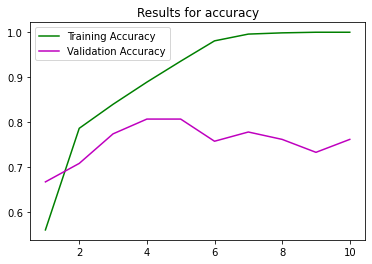

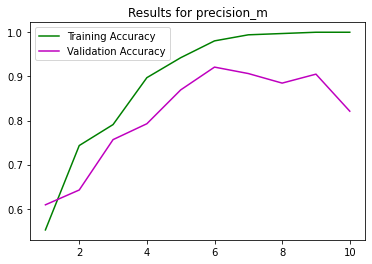

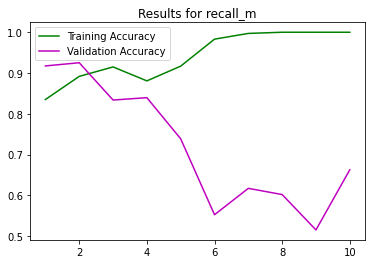

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy', color='g')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='m')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [77]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+10, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          30624     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 40,033
Trainable params: 40,033
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [79]:
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
23/23 [==============================] - 3s 32ms/step - loss: 0.6933 - accuracy: 0.4997 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.4979 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
23/23 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5118 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6916 - val_accuracy: 0.4979 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
23/23 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5634 - precision_m: 0.2690 - recall_m: 0.1805 - val_loss: 0.6835 - val_accuracy: 0.6255 - val_precision_m: 0.5757 - val_recall_m: 0.9096
Epoch 4/10
23/23 [==============================] - 0s 5ms/step - loss: 0.6709 - accuracy: 0.7294 - precision_m: 0.6885 - recall_m: 0.8645 - val_loss: 0.6650 - val_accuracy: 0.6379 - val_precision_m: 0.5811 - val_recall_m: 0.9309
Epoch 5/10
23/23 [=============================

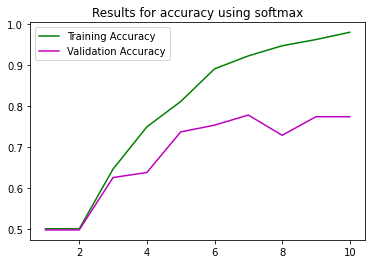

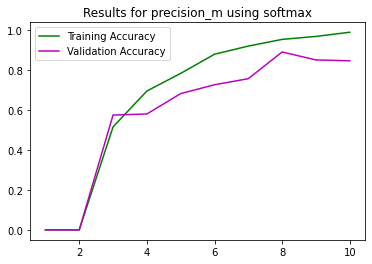

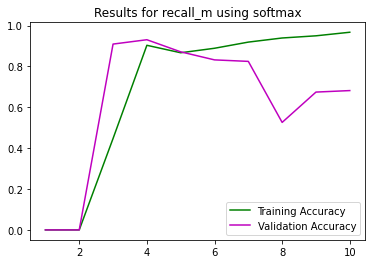

In [80]:
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy', color='g')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='m')
    plt.title('Results for {} using softmax'.format(i))
    plt.legend()
    plt.show()